In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, precision_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2025-05-04 11:31:02.961760: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-04 11:31:02.978919: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746338462.999414    9493 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746338463.005490    9493 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-04 11:31:03.026846: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Load datasets
true_df = pd.read_csv("News-_dataset/True.csv")
fake_df = pd.read_csv("News-_dataset/Fake.csv")

# Add labels
true_df['label'] = 1
fake_df['label'] = 0

# Combine and shuffle
df = pd.concat([true_df, fake_df], axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


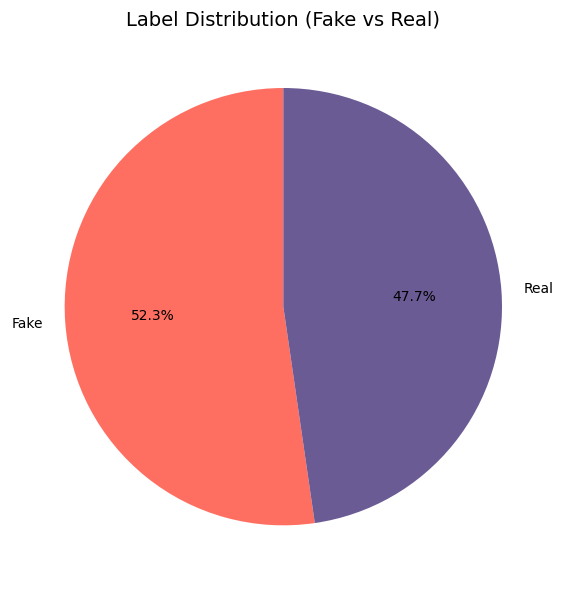

In [3]:
# Pie chart for class balance (Fake vs Real)
plt.figure(figsize=(6, 6))
colors = ['#FF6F61', '#6B5B95']
labels = ['Fake', 'Real']
df['label'].value_counts().plot.pie(autopct='%1.1f%%', labels=labels, colors=colors, startangle=90)
plt.title("Label Distribution (Fake vs Real)", fontsize=14)
plt.ylabel("")
plt.tight_layout()
plt.show()


In [4]:
# Drop nulls and duplicates
df.dropna(inplace=True)
df.drop_duplicates(subset=["title", "text"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39105 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    39105 non-null  object
 1   text     39105 non-null  object
 2   subject  39105 non-null  object
 3   date     39105 non-null  object
 4   label    39105 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.8+ MB


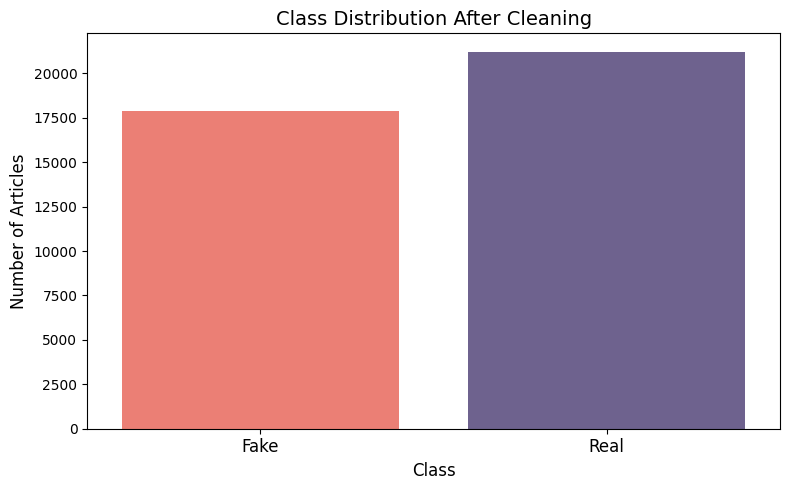

In [5]:
plt.figure(figsize=(8, 5))

# Custom colors for Fake and Real, and using 'hue' for proper palette association
sns.countplot(data=df, x='label', hue='label', palette=colors, legend=False)

# Titles and labels
plt.title("Class Distribution After Cleaning", fontsize=14)
plt.xticks([0, 1], ['Fake', 'Real'], fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xlabel("Class", fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


In [6]:
# Combine title and text
df['content'] = df['title'] + " " + df['text']
df.drop(columns=["title", "text", "date"], inplace=True)

df.head()

,subject,label,content
0,News,0,BREAKING: GOP Chairman Grassley Has Had Enoug...
1,News,0,Failed GOP Candidates Remembered In Hilarious...
2,News,0,Mike Pence’s New DC Neighbors Are HILARIOUSLY...
3,politicsNews,1,California AG pledges to defend birth control ...
4,politics,0,AZ RANCHERS Living On US-Mexico Border Destroy...


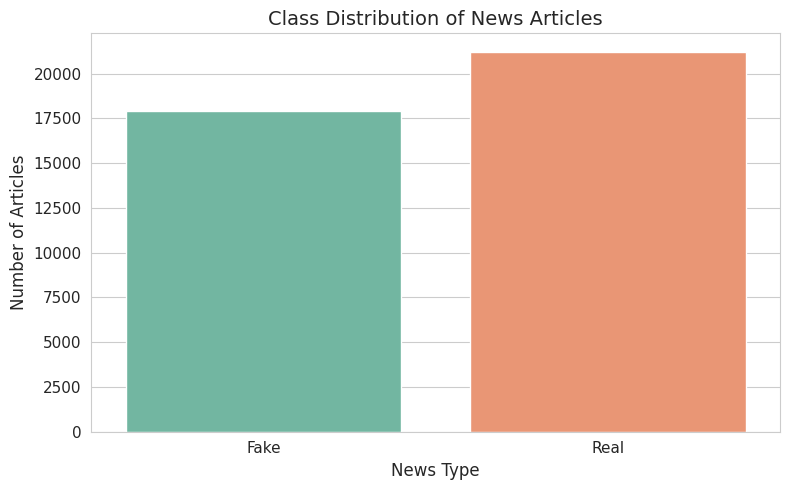

In [7]:
# Set style
sns.set_style("whitegrid")

# Plot with hue for color mapping and suppress the legend
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='label', hue='label', palette='Set2', legend=False)

# Custom titles and labels
plt.title("Class Distribution of News Articles", fontsize=14)
plt.xlabel("News Type", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks([0, 1], ['Fake', 'Real'], fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

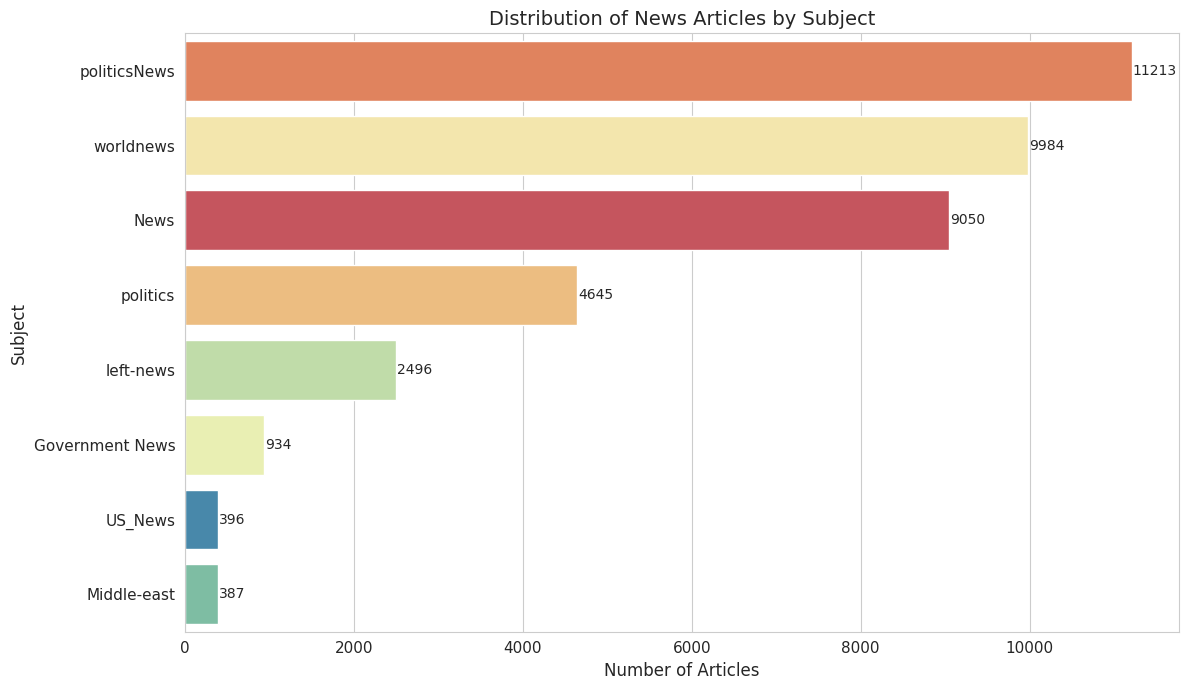

In [8]:
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Use hue='subject' to map colors properly and suppress the legend
sns.countplot(data=df, y='subject', order=df['subject'].value_counts().index,
              hue='subject', palette='Spectral', legend=False)

# Add count labels to bars
for p in plt.gca().patches:
    plt.text(p.get_width() + 10, p.get_y() + p.get_height() / 2,
             f'{int(p.get_width())}', va='center', fontsize=10)


plt.title("Distribution of News Articles by Subject", fontsize=14)
plt.xlabel("Number of Articles", fontsize=12)
plt.ylabel("Subject", fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


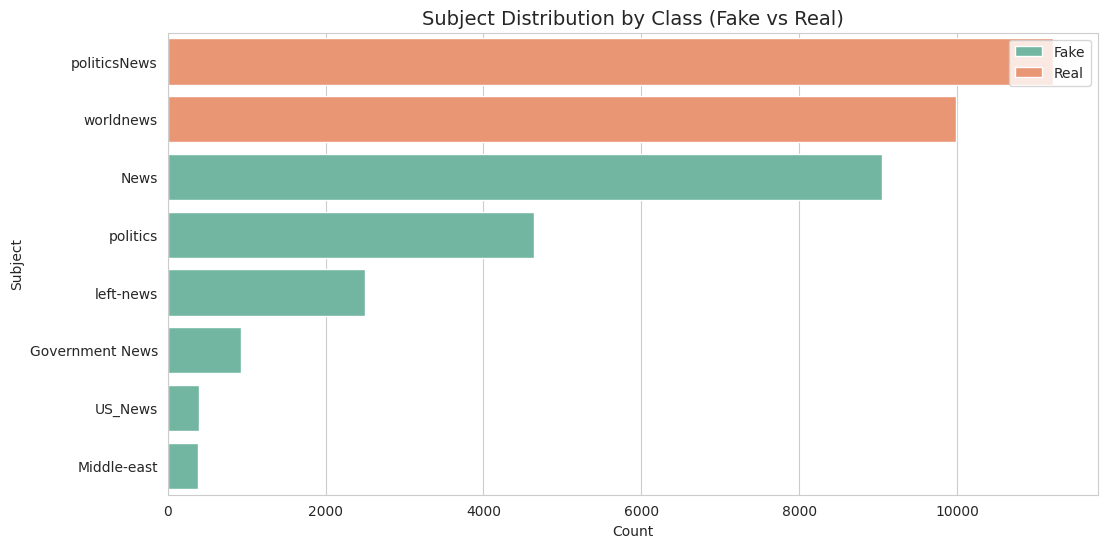

In [9]:
# Top subjects by label
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='subject', hue='label', order=df['subject'].value_counts().index, palette='Set2')
plt.title("Subject Distribution by Class (Fake vs Real)", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Subject")
plt.legend(['Fake', 'Real'], loc='upper right')
plt.show()


In [10]:
df_copy = df.copy(deep=True)

In [11]:
df = df_copy.copy(deep=True)
def clean_text(text):
    # Remove "(Reuters) - " and similar patterns *anywhere* in the text
    text = re.sub(r'\b\w+\s+\(?Reuters\)?\s*-\s+', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\(?Reuters\)?\s*-\s+', '', text, flags=re.IGNORECASE)

    # Identify last sentence using rpartition (better precision)
    text = text.strip()
    last_dot_idx = text.rstrip().rfind('.')  # find last period

    if last_dot_idx != -1:
        before_last, sep, last_sentence = text.rpartition('.')
        if re.search(r'\b(images?|capture|featured|via)\b', last_sentence, re.IGNORECASE):
            text = before_last + '.'  # keep everything before last sentence
        else:
            text = before_last + '.' + last_sentence  # nothing to remove
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # Remove non-letter characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Lowercase and strip extra spaces
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()

    return text

# Apply to the merged title + text content
df['raw_len'] = df['content'].apply(lambda x: len(x.split()))
df['clean_content'] = df['content'].apply(clean_text)
df['clean_len'] = df['clean_content'].apply(lambda x: len(x.split()))


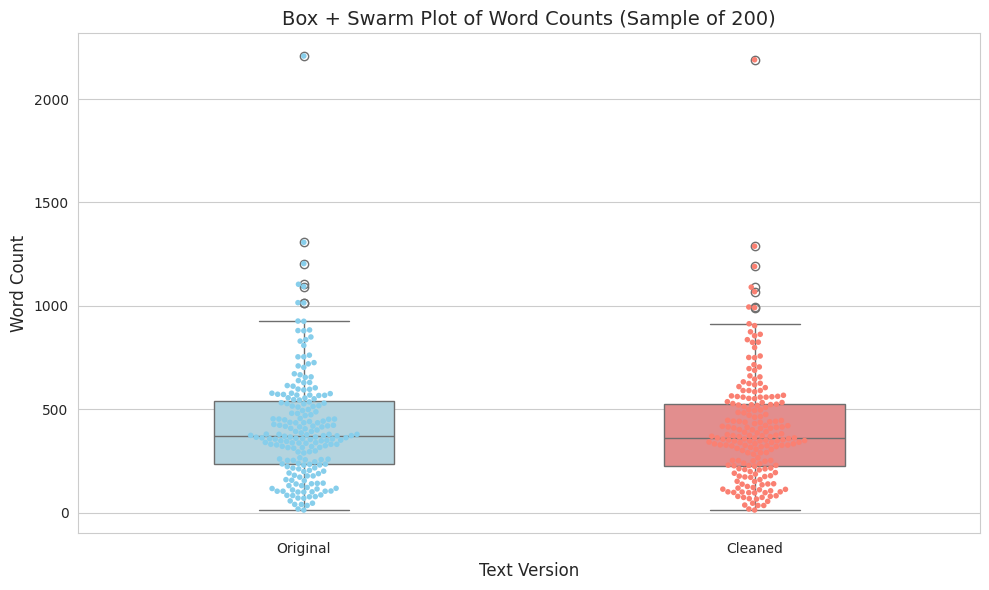

In [12]:
# Sample a smaller subset to speed up plotting
sample_df = df.sample(200, random_state=42)

# Prepare melted sample
melted_sample = pd.melt(sample_df[['raw_len', 'clean_len']],
                        var_name='Type', value_name='Word Count')
melted_sample['Type'] = melted_sample['Type'].map({'raw_len': 'Original', 'clean_len': 'Cleaned'})

plt.figure(figsize=(10, 6))
sns.boxplot(data=melted_sample, x='Type', y='Word Count', hue='Type', 
            palette=['lightblue', 'lightcoral'], width=0.4)
sns.swarmplot(data=melted_sample, x='Type', y='Word Count', hue='Type',
              palette=['skyblue', 'salmon'], size=4, dodge=False, legend=False)

plt.title("Box + Swarm Plot of Word Counts (Sample of 200)", fontsize=14)
plt.xlabel("Text Version", fontsize=12)
plt.ylabel("Word Count", fontsize=12)
plt.tight_layout()
plt.show()



Original [32164]:
ization, and passing the proposed TPP,” Navarro and Gray wrote.  “These deals only weaken our manufacturing base and ability to defend ourselves and our allies.” Trump has vowed to pull the United States out of the TPP, a free-trade pact aimed at linking a dozen Pacific Rim nations that President Barack Obama signed in February. It has not been ratified by the U.S. Senate.  The president-elect has also vowed to renegotiate the NAFTA pact with Canada and Mexico, saying it had cost American jobs. 

Cleaned  [32164]:
e world trade organization and passing the proposed tpp navarro and gray wrote these deals only weaken our manufacturing base and ability to defend ourselves and our allies trump has vowed to pull the united states out of the tpp a freetrade pact aimed at linking a dozen pacific rim nations that president barack obama signed in february it has not been ratified by the us senate the presidentelect has also vowed to renegotiate the nafta pact with canada and 

/tmp/ipykernel_9493/2445493050.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['raw_len'], label='Original Content', shade=True)
/tmp/ipykernel_9493/2445493050.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['clean_len'], label='Cleaned Content', shade=True)


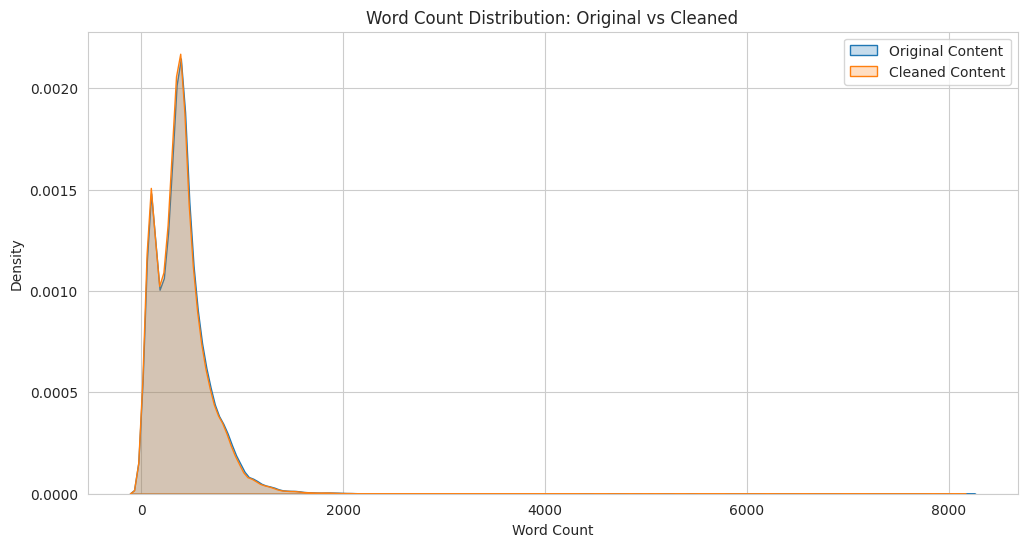

In [13]:
# Show side-by-side comparison of raw vs cleaned content
comparison_df = df[['content', 'clean_content']].sample(50, random_state=42)
for i, row in comparison_df.iterrows():
    # print(f"\nOriginal [{i}]:\n{row['content'][:500]}")
    # print(f"\nCleaned  [{i}]:\n{row['clean_content'][:500]}")
    # print("="*100)
    print(f"\nOriginal [{i}]:\n{row['content'][-500:]}")
    print(f"\nCleaned  [{i}]:\n{row['clean_content'][-500:]}")
    print("="*100)

# Compute length differences
df['raw_len'] = df['content'].apply(lambda x: len(x.split()))
df['clean_len'] = df['clean_content'].apply(lambda x: len(x.split()))
df['reduction'] = df['raw_len'] - df['clean_len']

# Print average reduction
print(f"\nAverage word count reduction: {df['reduction'].mean():.2f} words per article")

# Visualize word count distributions
plt.figure(figsize=(12, 6))
sns.kdeplot(df['raw_len'], label='Original Content', shade=True)
sns.kdeplot(df['clean_len'], label='Cleaned Content', shade=True)
plt.title("Word Count Distribution: Original vs Cleaned")
plt.xlabel("Word Count")
plt.legend()
plt.show()


In [14]:
import numpy as np
from statistics import mode, StatisticsError

# Calculate word counts for each article
df['word_count'] = df['clean_content'].apply(lambda x: len(x.split()))

# Compute statistics
avg_words = df['word_count'].mean()
max_words = df['word_count'].max()
min_words = df['word_count'].min()
median_words = df['word_count'].median()

try:
    mode_words = mode(df['word_count'])
except StatisticsError:
    mode_words = "No unique mode"

# Display results
print(f"Word Count Stats in `clean_content`:")
print(f"Average: {avg_words:.2f} words")
print(f"Maximum: {max_words} words")
print(f"Minimum: {min_words} words")
print(f"Median: {median_words} words")
print(f"Mode: {mode_words}")

Word Count Stats in `clean_content`:
Average: 402.01 words
Maximum: 8057 words
Minimum: 0 words
Median: 370.0 words
Mode: 404


In [15]:
print(f"Cleaned DataFrame shape: {df.shape}")

Cleaned DataFrame shape: (39105, 8)


In [16]:
# Recalculate word count in case it's outdated
df['word_count'] = df['clean_content'].apply(lambda x: len(x.split()))

# Get indexes where word count is 6 or less
zero_word_indexes = df[df['word_count'] <= 6].index.tolist()

# Display
print(f"Total rows with 6 words or less: {len(zero_word_indexes)}")
print(f"Indexes: {zero_word_indexes}")


Total rows with 6 words or less: 9
Indexes: [24, 11343, 13493, 13550, 16730, 18327, 18825, 26511, 40247]


In [17]:
# Drop rows where word count is less than or equal to 6
df = df[df['word_count'] > 6].reset_index(drop=True)

print(f"Cleaned DataFrame shape: {df.shape}")

Cleaned DataFrame shape: (39096, 8)


In [18]:
import numpy as np
from statistics import mode, StatisticsError

# Calculate word counts for each article
df['word_count'] = df['clean_content'].apply(lambda x: len(x.split()))

# Compute statistics
avg_words = df['word_count'].mean()
max_words = df['word_count'].max()
min_words = df['word_count'].min()
median_words = df['word_count'].median()

try:
    mode_words = mode(df['word_count'])
except StatisticsError:
    mode_words = "No unique mode"

# Display results
print(f"Word Count Stats in `clean_content`:")
print(f"Average: {avg_words:.2f} words")
print(f"Maximum: {max_words} words")
print(f"Minimum: {min_words} words")
print(f"Median: {median_words} words")
print(f"Mode: {mode_words}")

Word Count Stats in `clean_content`:
Average: 402.10 words
Maximum: 8057 words
Minimum: 7 words
Median: 370.0 words
Mode: 404


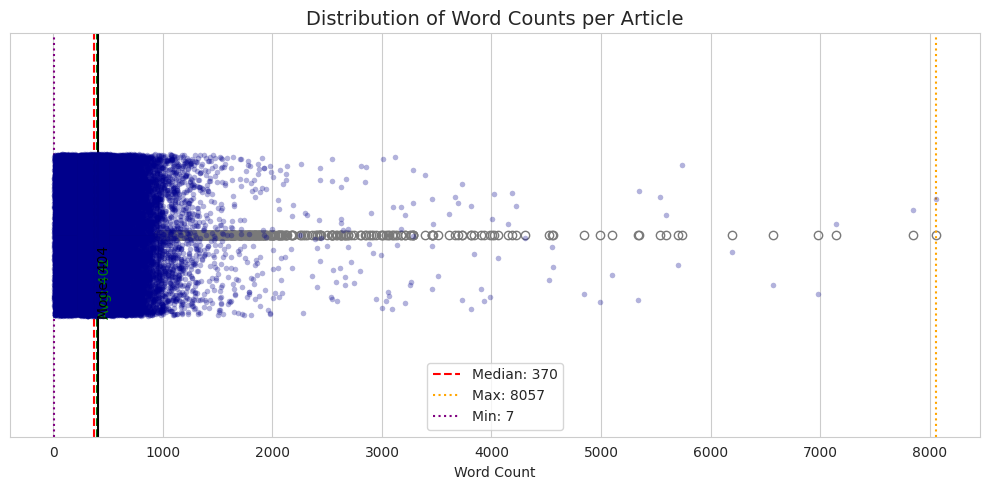

In [19]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['word_count'], color='lightblue', width=0.4)
sns.stripplot(x=df['word_count'], color='darkblue', alpha=0.3, jitter=0.2, size=4)

# Annotate statistics with vertical lines
plt.axvline(avg_words, color='green', linestyle='--')
plt.text(avg_words + 2, 0.2, f'Avg: {avg_words:.0f}', rotation=90, color='green')

plt.axvline(mode_words, color='black', linestyle='-')
plt.text(mode_words - 4, 0.2, f'Mode: {mode_words}', rotation=90, color='black')

plt.axvline(median_words, color='red', linestyle='--', label=f'Median: {median_words:.0f}')
plt.axvline(max_words, color='orange', linestyle=':', label=f'Max: {max_words}')
plt.axvline(min_words, color='purple', linestyle=':', label=f'Min: {min_words}')


plt.title("Distribution of Word Counts per Article", fontsize=14)
plt.xlabel("Word Count")
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
from collections import Counter

# Compute word counts
word_counts = df['clean_content'].apply(lambda x: len(x.split()))

# Create frequency map
word_count_freq = Counter(word_counts)

# Convert to a sorted dictionary (ascending by word count)
sorted_word_count_freq = dict(sorted(word_count_freq.items()))

# Display the result
print("Word Count Frequency (word_count: num_rows):")
for count, freq in sorted_word_count_freq.items():
    print(f"{count}: {freq}")



Word Count Frequency (word_count: num_rows):
7: 6
8: 10
9: 20
10: 28
11: 47
12: 56
13: 67
14: 64
15: 55
16: 45
17: 51
18: 31
19: 28
20: 21
21: 24
22: 18
23: 26
24: 17
25: 21
26: 24
27: 20
28: 17
29: 26
30: 25
31: 35
32: 31
33: 34
34: 37
35: 35
36: 32
37: 25
38: 29
39: 34
40: 30
41: 31
42: 31
43: 25
44: 31
45: 27
46: 36
47: 37
48: 34
49: 33
50: 30
51: 29
52: 26
53: 32
54: 39
55: 43
56: 43
57: 31
58: 43
59: 34
60: 46
61: 50
62: 46
63: 57
64: 61
65: 47
66: 62
67: 51
68: 71
69: 60
70: 73
71: 90
72: 61
73: 80
74: 87
75: 79
76: 93
77: 87
78: 86
79: 86
80: 87
81: 87
82: 93
83: 92
84: 100
85: 105
86: 81
87: 84
88: 83
89: 88
90: 100
91: 80
92: 77
93: 83
94: 84
95: 88
96: 90
97: 88
98: 76
99: 96
100: 74
101: 70
102: 73
103: 76
104: 75
105: 78
106: 78
107: 59
108: 53
109: 66
110: 56
111: 55
112: 57
113: 70
114: 59
115: 60
116: 54
117: 52
118: 57
119: 56
120: 61
121: 55
122: 56
123: 43
124: 47
125: 60
126: 57
127: 49
128: 52
129: 41
130: 49
131: 53
132: 52
133: 53
134: 43
135: 45
136: 43
137: 45
1

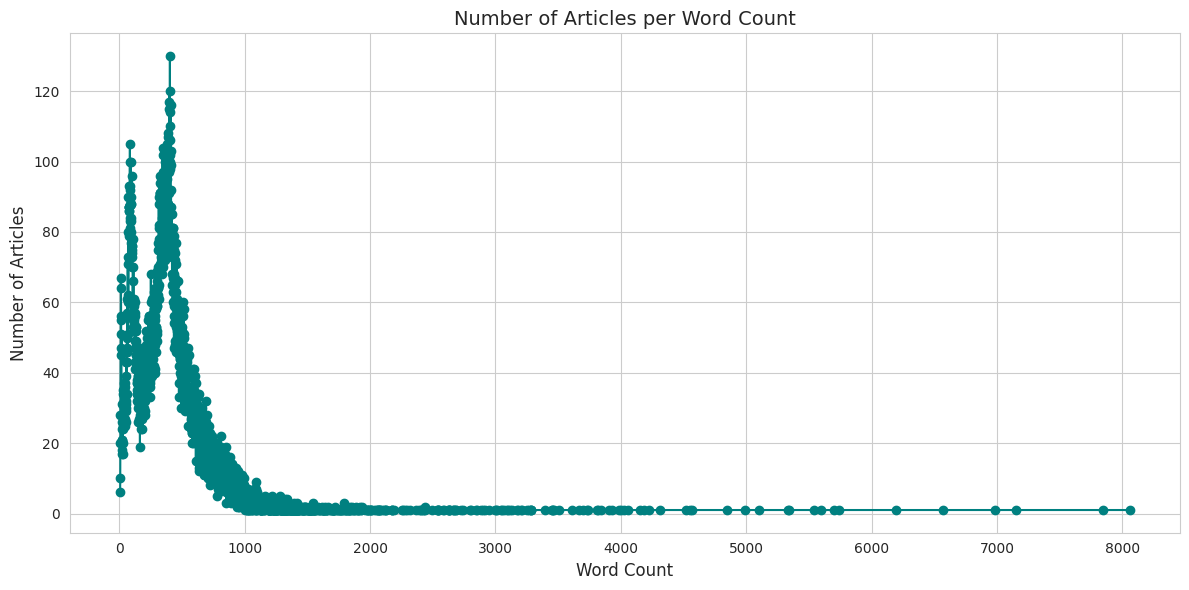

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(list(sorted_word_count_freq.keys()), list(sorted_word_count_freq.values()), marker='o', color='teal')

plt.title("Number of Articles per Word Count", fontsize=14)
plt.xlabel("Word Count", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


### Tokenizer

In [22]:
import numpy as np
word_counts = df['clean_content'].apply(lambda x: len(x.split()))
print(f"Max: {word_counts.max()}, 95th percentile: {np.percentile(word_counts, 95)}, Median: {word_counts.median()}")


Max: 8057, 95th percentile: 875.0, Median: 370.0


In [23]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_content'])
print(f"Total unique tokens: {len(tokenizer.word_index)}")


sequences = tokenizer.texts_to_sequences(df['clean_content'])
max_len = 875
X = pad_sequences(sequences, maxlen=max_len)
y = df['label'].values


Total unique tokens: 208228


### Train test val split (70:20:10)

In [24]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/8, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 27366, Val: 3910, Test: 7820


In [25]:
import numpy as np

# For y_train
train_counts = np.bincount(y_train)
print(f"Train - Class 0: {train_counts[0]}, Class 1: {train_counts[1]}")

# For y_val
val_counts = np.bincount(y_val)
print(f"Validation - Class 0: {val_counts[0]}, Class 1: {val_counts[1]}")

# For y_test
test_counts = np.bincount(y_test)
print(f"Test - Class 0: {test_counts[0]}, Class 1: {test_counts[1]}")


Train - Class 0: 12530, Class 1: 14836
Validation - Class 0: 1790, Class 1: 2120
Test - Class 0: 3580, Class 1: 4240


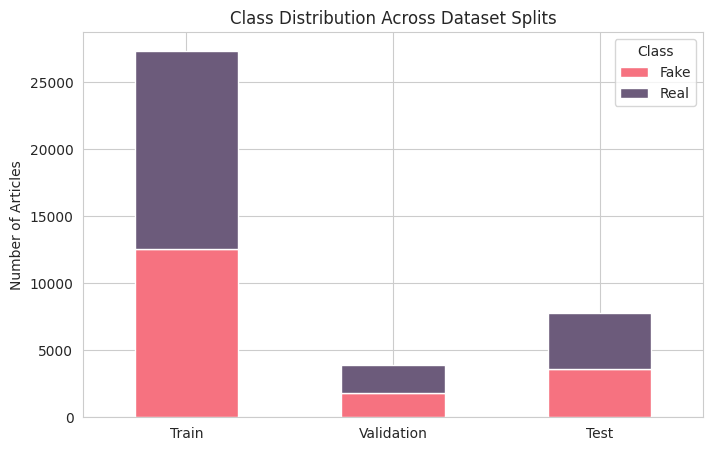

In [26]:
# Stacked bar chart for dataset split class distribution
split_labels = ['Train', 'Validation', 'Test']
split_data = [y_train, y_val, y_test]
counts = [np.bincount(y) for y in split_data]

df_split = pd.DataFrame(counts, columns=['Fake', 'Real'], index=split_labels)
df_split.plot(kind='bar', stacked=True, figsize=(8, 5), color=['#F67280', '#6C5B7B'])
plt.title("Class Distribution Across Dataset Splits")
plt.ylabel("Number of Articles")
plt.xticks(rotation=0)
plt.legend(title="Class")
plt.show()
